In [1]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt
import sklearn as sk
import scipy

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_fdata()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)
from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(
smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face', dtype=np.short)
print('The only relevant horizontal brain slice has %i voxels.' % process_mask[...,
picked_slice].sum())

data = np.concatenate( (fmri_masked,output_variable[:,np.newaxis]), axis =1)

height,width = data.shape
width-=1

def bootstrap(data):
    
    length = data.shape[0]
    
    return data[np.random.randint(length,size=length)]

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


The only relevant horizontal brain slice has 739 voxels.


In [2]:
# TASK 6

np.random.seed(1)

np.random.seed(1)

coefmat=np.zeros((200,width))

for i in range(200):
    bs = bootstrap(data)
    model = sk.linear_model.LogisticRegression(max_iter= 10000).fit(bs[:,:width], bs[:,width])
    coefmat[i]=model.coef_

model = sk.linear_model.LogisticRegression(max_iter= 10000).fit(data[:,:width], data[:,width])


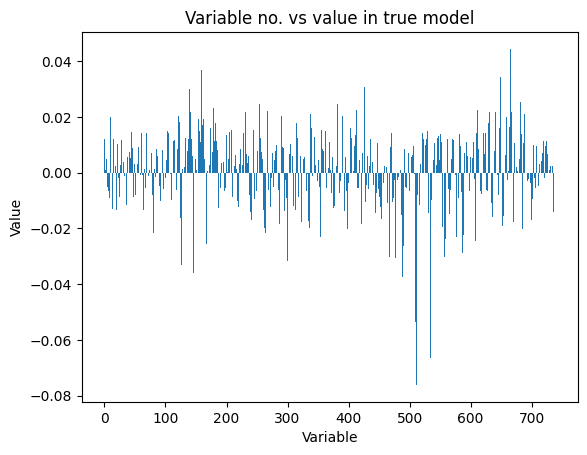

In [3]:
#Task 6

plt.bar(range(0,width),model.coef_.flatten())
plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Variable no. vs value in true model")
plt.show()

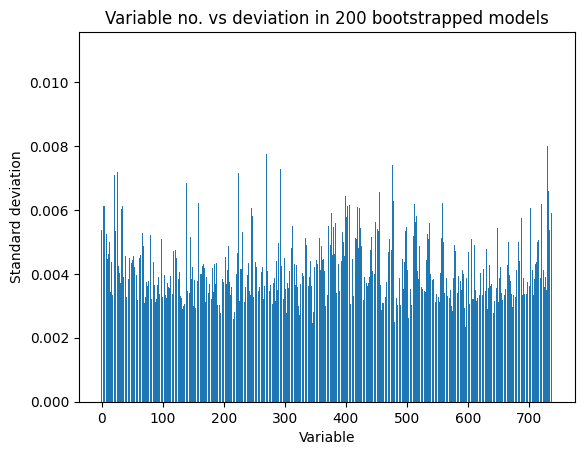

In [4]:
plt.bar(range(0,width),np.std(coefmat,0))
plt.xlabel("Variable")
plt.ylabel("Standard deviation")
plt.title("Variable no. vs deviation in 200 bootstrapped models")
plt.show()

In [5]:
# TASK 7

np.random.seed(2)
def seperatestrap(data):
    length = data.shape[0]
    i_array=np.random.randint(length,size=length)
    m=[]
    f=[]
    for i in i_array:
        row = data[i]
        if row[width]==1:
            f.append(row[:width])
        elif row[width]==0:
            m.append(row[:width])
        else:
            raise Exception("Non boolean data in last column")
        
    m=np.array(m)
    f=np.array(f)
    return (m,f)

pmat=np.zeros((200,width))

for i in range(200):
    (m,f)=seperatestrap(data)
    pmat[i]=scipy.stats.ttest_ind(m,f).pvalue

logpmat=-np.log(pmat)
logpmat=np.sort(logpmat,axis=0)

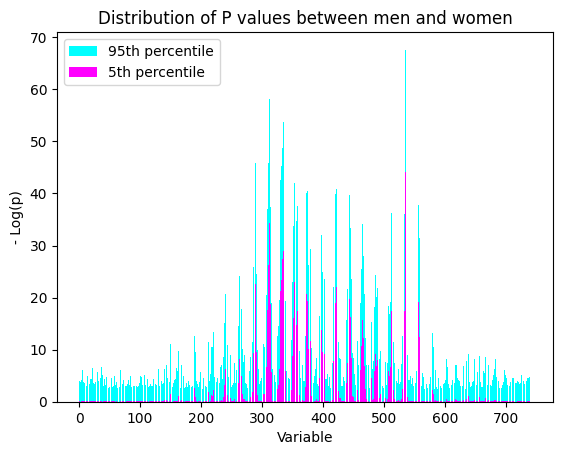

In [7]:
pctile_5 = logpmat[10,:]
pctile_95 = logpmat[190,:]
x=np.array(range(1,width+1))
plt.bar(x,pctile_95,color='#00FFFF')
plt.bar(x,pctile_5, color = '#FF00FF')
plt.legend(["95th percentile","5th percentile"])

x=np.array(range(1,width+1))
x=np.repeat(np.transpose(x[:,np.newaxis]),200,axis=0)+np.random.rand(200,width)/3-np.ones((200,width))/6

plt.xlabel("Variable")
plt.ylabel("- Log(p)")
plt.title("Distribution of P values between men and women")

plt.show()

In [26]:
# TASK 8
np.random.seed(3)

shuffleddata = np.copy(data)
np.random.shuffle(shuffleddata)
cutoff= round(height*0.8)
testsize = height-cutoff
traindata=shuffleddata[:cutoff]
testdata=shuffleddata[cutoff:]

votes = np.zeros((testsize))
meanmodelcoef = np.zeros((1,width))


for i in range(200):
    bs = bootstrap(traindata)
    model = sk.linear_model.LogisticRegression(max_iter= 10000).fit(bs[:,0:width], bs[:,width])
    meanmodelcoef += model.coef_
    votes+= model.predict(testdata[:,:width])

meanmodelcoef/=200

prediction = (votes/200 > 0.5)
performance = np.sum(prediction==testdata[:,width]) *100/testsize
performance = round(performance,2)
print("Classification performance for majority vote model is "+str(performance)+"%")

Classification performance for majority vote model is 95.35%


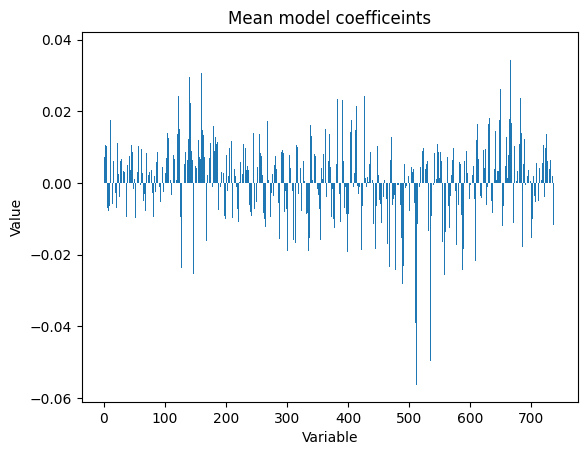

Classification performance for mean coefficient model is 95.349%


In [27]:
#Task 9

x=np.array(range(1,width+1))
plt.bar(x,meanmodelcoef.flatten())
plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Mean model coefficeints")
plt.show()

model.coef_=meanmodelcoef
prediction = model.predict(testdata[:,:width])
performance = np.sum(prediction==testdata[:,width])*100/43
performance = round(performance,3)
print("Classification performance for mean coefficient model is "+str(performance)+"%")

In [18]:
# TASK 10
np.random.seed(5)

def remainderstrap(data):
    length = data.shape[0]
    i_array=np.random.randint(length,size=length)
    r_array=np.full((length), True)
    r_array[i_array]=False

    bs = data[i_array]
    remainder = data[r_array]

    return (bs,remainder)


meanmodelcoef = np.zeros((1,width))

attempts = 0
correct_answers = 0

for i in range(200):
    (bs,r)=remainderstrap(data)
    model = sk.linear_model.LogisticRegression(max_iter= 10000).fit(bs[:,:width], bs[:,width])
    meanmodelcoef += model.coef_

    predictions = model.predict(r[:,:width])

    correct_answers += np.sum(predictions == r[:,width])
    attempts += len(predictions)
    
meanmodelcoef/=200
performance = correct_answers/attempts
performance = round(performance*100,2)


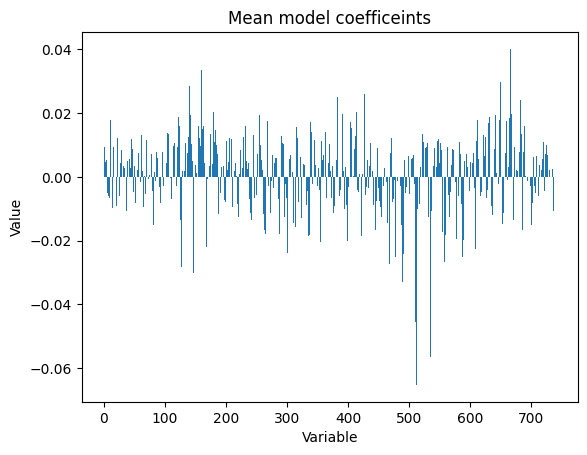

Average performance via out-of-bags evaluation is 98.55%


In [19]:
x=np.array(range(1,width+1))
plt.bar(x,meanmodelcoef.flatten())

plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Mean model coefficeints")
plt.show()

print("Average performance via out-of-bags evaluation is "+str(performance)+"%")